# Heart Disease Prediction — Cleveland Dataset

## Project Overview
In this notebook, we build a **binary classification model** to predict the presence of heart disease using the **Cleveland Heart Disease dataset**. The dataset contains 303 patient records with 13 clinical features and 1 target variable (`condition`: 0 = No Disease, 1 = Disease).

**Our workflow:**
1. **Exploratory Data Analysis (EDA)** — understand data shape, missing values, class balance, correlations, and distributions
2. **Data Preprocessing** — handle class imbalance, encode categoricals, cap outliers, engineer interaction features, and scale numericals
3. **Model Building** — train Logistic Regression and XGBoost classifiers, tune hyperparameters, and compare performance
4. **Feature Importance** — identify which clinical features are the strongest predictors of heart disease

---

## 1. Data Exploration and Preprocessing
We start by loading the data and getting an initial understanding of its structure, data types, and missing values.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [87]:
df = pd.read_csv(r'C:\Users\redmi\Downloads\Problem-A-20260213T090732Z-1-001\Problem-A\dataset\heart_cleveland_upload.csv')

In [88]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [89]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,1.000000


In [90]:
df.isnull().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64

#### Insight 1: No Missing Values
The dataset is clean — there are **zero missing values** across all 14 columns. This means we can proceed directly to analyzing the target distribution without needing any imputation strategies.

Next, let's check how balanced our target classes are, since class imbalance can significantly affect model performance.

In [91]:
class_counts = df['condition'].value_counts()
print(class_counts)
print("\nClass balance (proportions):")
print(df['condition'].value_counts(normalize=True))

condition
0    160
1    137
Name: count, dtype: int64

Class balance (proportions):
condition
0    0.538721
1    0.461279
Name: proportion, dtype: float64


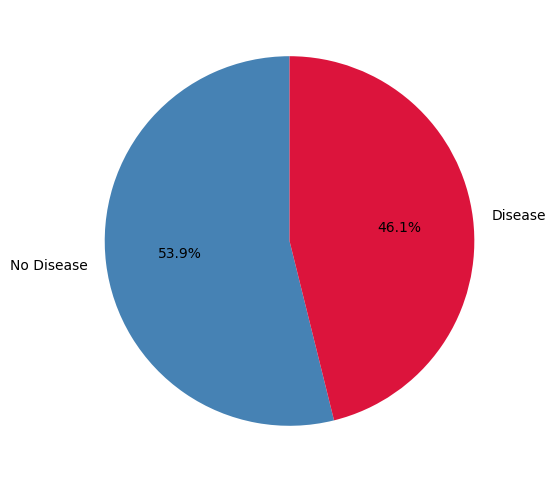


Imbalance ratio: 1.17:1
Majority class: 160 | Minority class: 137
Mild imbalance detected.


In [92]:
plt.pie(class_counts.values, labels=['No Disease', 'Disease'],
            autopct='%1.1f%%', colors=['steelblue', 'crimson'], startangle=90)
plt.show()

# Imbalance ratio
majority = class_counts.max()
minority = class_counts.min()
imbalance_ratio = majority / minority
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")
print(f"Majority class: {majority} | Minority class: {minority}")
if imbalance_ratio > 1.5:
    print("Significant class imbalance detected.")
else:
    print("Mild imbalance detected.")

### Insight 2 : Imbalanced Dataset

#### Handling Class Imbalance
 **Random Downsampling** (reduce majority to match minority)  


In [93]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

df_majority = df[df['condition'] == 0]
df_minority = df[df['condition'] == 1]

df_majority_down = resample(df_majority, replace=False,
                            n_samples=len(df_minority), random_state=42)
df_downsampled = pd.concat([df_majority_down, df_minority])

print("=== Downsampling Result ===")
print(df_downsampled['condition'].value_counts())
print(f"Total samples: {len(df_downsampled)}")


=== Downsampling Result ===
condition
0    137
1    137
Name: count, dtype: int64
Total samples: 274


In [94]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
age,1.000000,-0.092399,0.110471,0.290476,0.202644,0.132062,0.149917,-0.394563,0.096489,0.197123,0.159405,0.362210,0.120795,0.227075
sex,-0.092399,1.000000,0.008908,-0.066340,-0.198089,0.038850,0.033897,-0.060496,0.143581,0.106567,0.033345,0.091925,0.370556,0.278467
cp,0.110471,0.008908,1.000000,-0.036980,0.072088,-0.057663,0.063905,-0.339308,0.377525,0.203244,0.151079,0.235644,0.266275,0.408945
trestbps,0.290476,-0.066340,-0.036980,1.000000,0.131536,0.180860,0.149242,-0.049108,0.066691,0.191243,0.121172,0.097954,0.130612,0.153490
chol,0.202644,-0.198089,0.072088,0.131536,1.000000,0.012708,0.165046,-0.000075,0.059339,0.038596,-0.009215,0.115945,0.023441,0.080285
fbs,0.132062,0.038850,-0.057663,0.180860,0.012708,1.000000,0.068831,-0.007842,-0.000893,0.008311,0.047819,0.152086,0.051038,0.003167
restecg,0.149917,0.033897,0.063905,0.149242,0.165046,0.068831,1.000000,-0.072290,0.081874,0.113726,0.135141,0.129021,0.013612,0.166343
thalach,-0.394563,-0.060496,-0.339308,-0.049108,-0.000075,-0.007842,-0.072290,1.000000,-0.384368,-0.347640,-0.389307,-0.268727,-0.258386,-0.423817
exang,0.096489,0.143581,0.377525,0.066691,0.059339,-0.000893,0.081874,-0.384368,1.000000,0.289310,0.250572,0.148232,0.323268,0.421355
oldpeak,0.197123,0.106567,0.203244,0.191243,0.038596,0.008311,0.113726,-0.347640,0.289310,1.000000,0.579037,0.294452,0.336809,0.424052


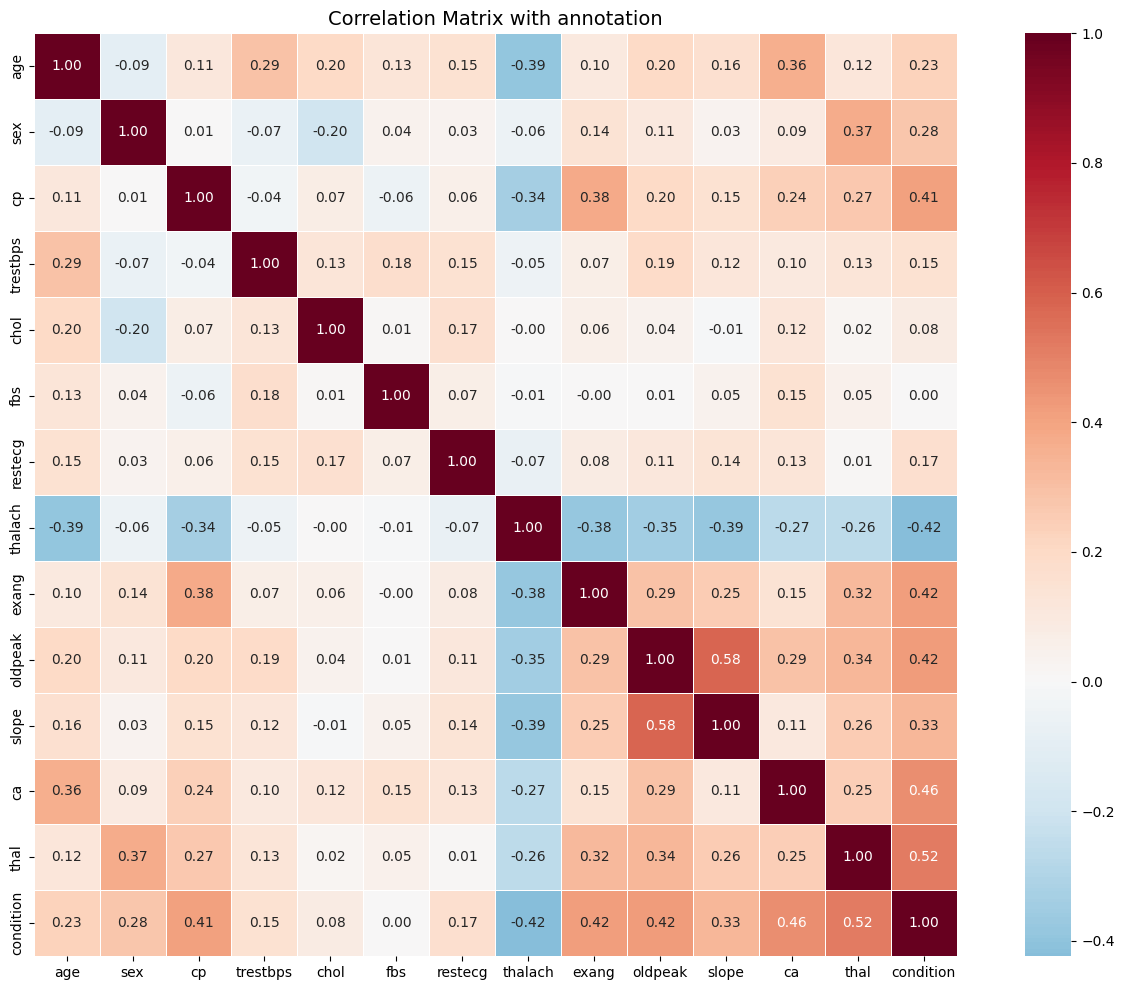

In [95]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            linewidths=0.5, square=True)
plt.title('Correlation Matrix with annotation', fontsize=14)
plt.tight_layout()
plt.show()

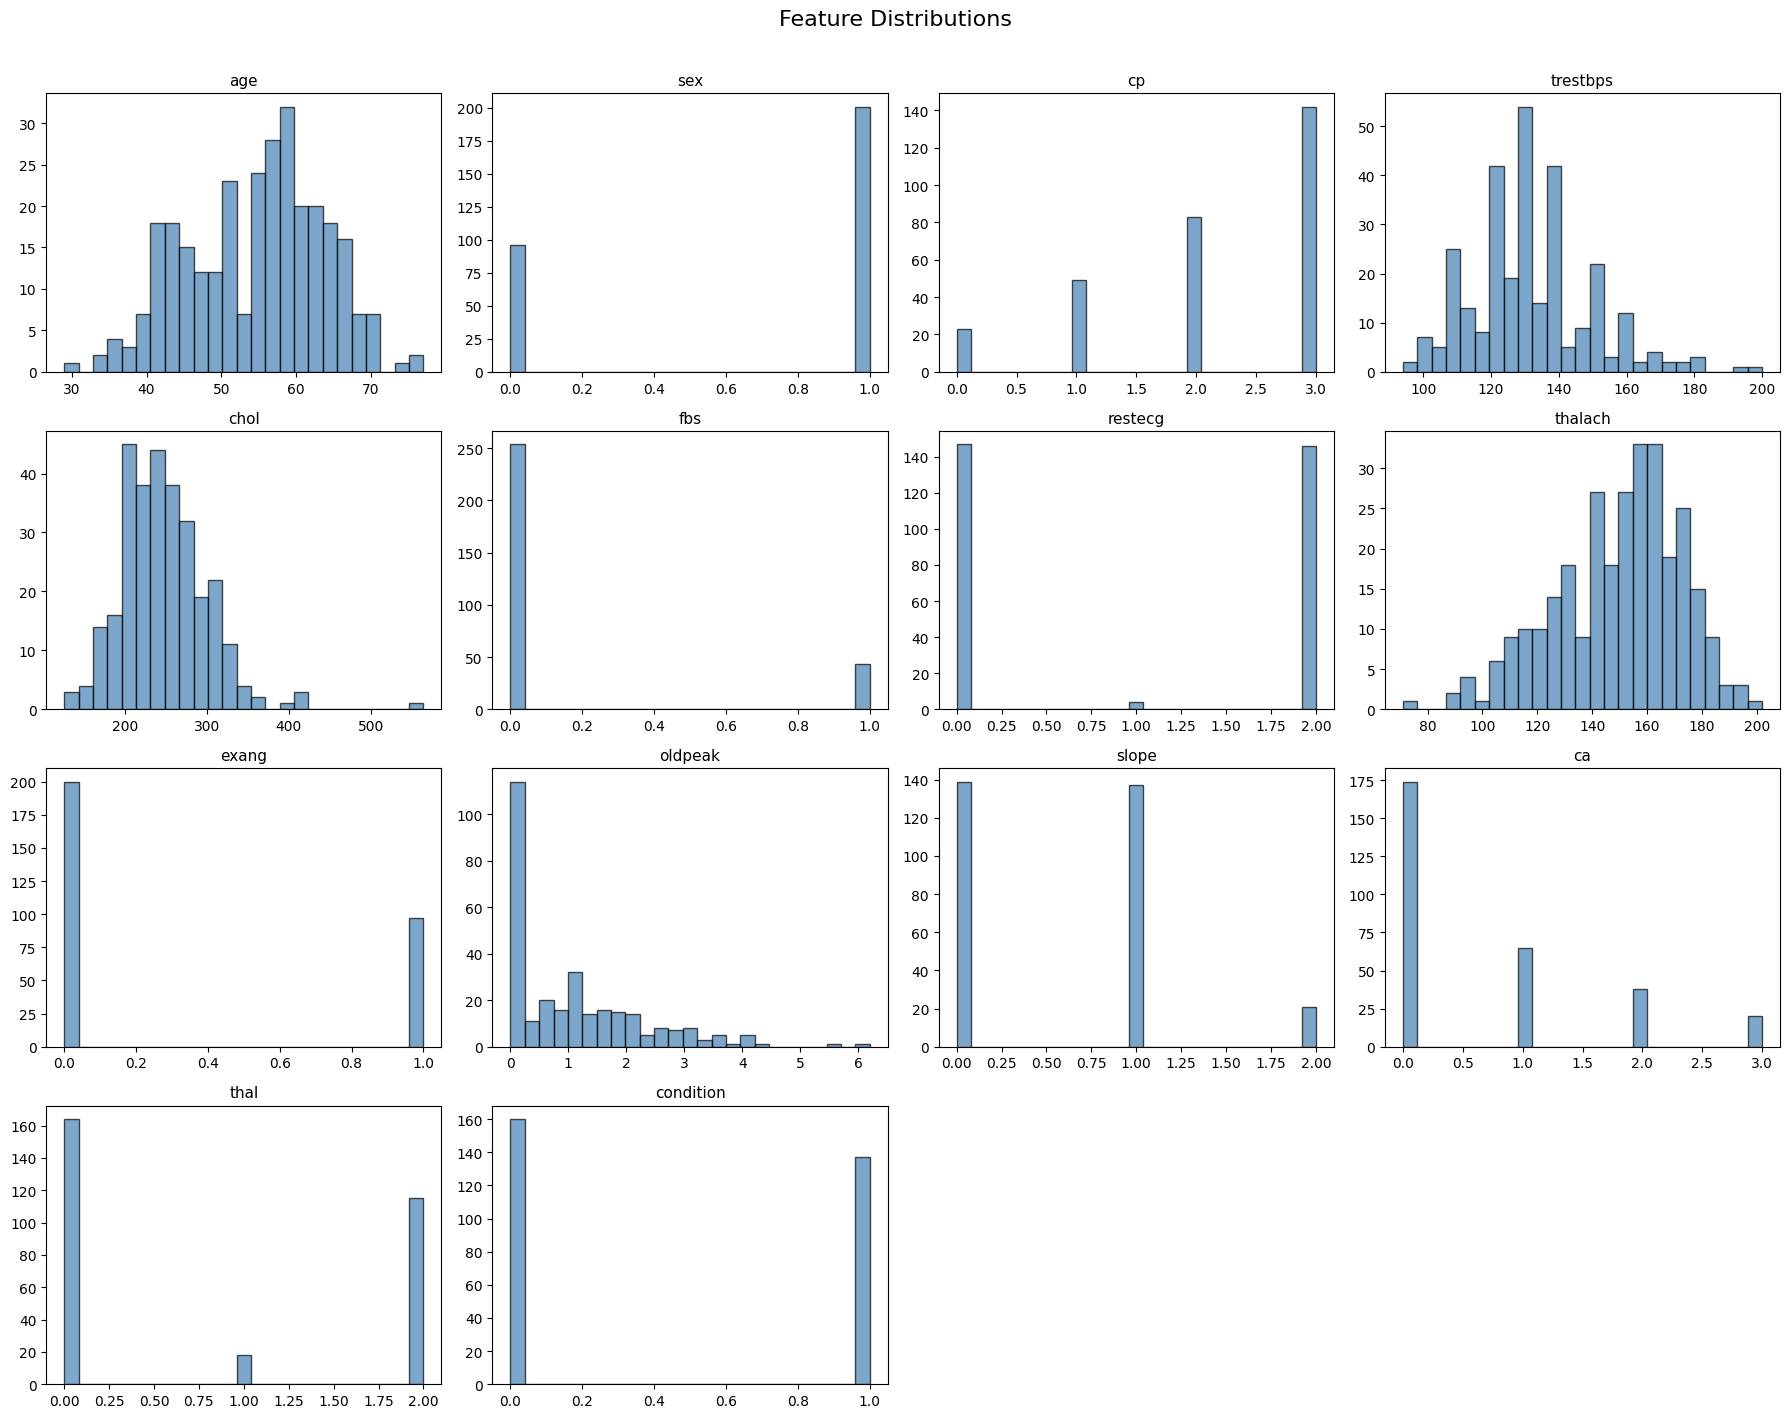

In [96]:
fig, axes = plt.subplots(4, 4, figsize=(18, 14))
axes = axes.ravel()
for i, col in enumerate(df.columns):
    axes[i].hist(df[col], bins=25, edgecolor='black', alpha=0.7, color='steelblue')
    axes[i].set_title(col, fontsize=11)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.suptitle('Feature Distributions', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

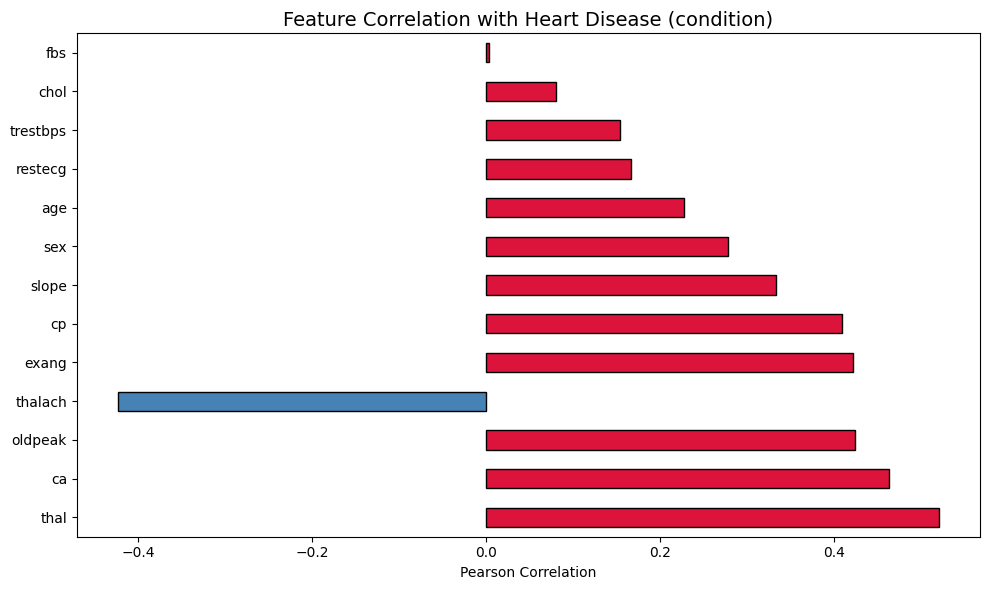


Top indicators of heart disease:
thal        0.520516
ca          0.463189
oldpeak     0.424052
thalach    -0.423817
exang       0.421355
cp          0.408945
slope       0.333049
sex         0.278467
age         0.227075
restecg     0.166343
trestbps    0.153490
chol        0.080285
fbs         0.003167
Name: condition, dtype: float64


In [97]:
target_corr = df.corr()['condition'].drop('condition').sort_values(key=abs, ascending=False)
plt.figure(figsize=(10, 6))
colors = ['crimson' if v > 0 else 'steelblue' for v in target_corr.values]
target_corr.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Feature Correlation with Heart Disease (condition)', fontsize=14)
plt.xlabel('Pearson Correlation')
plt.tight_layout()
plt.show()
print("\nTop indicators of heart disease:")
print(target_corr)

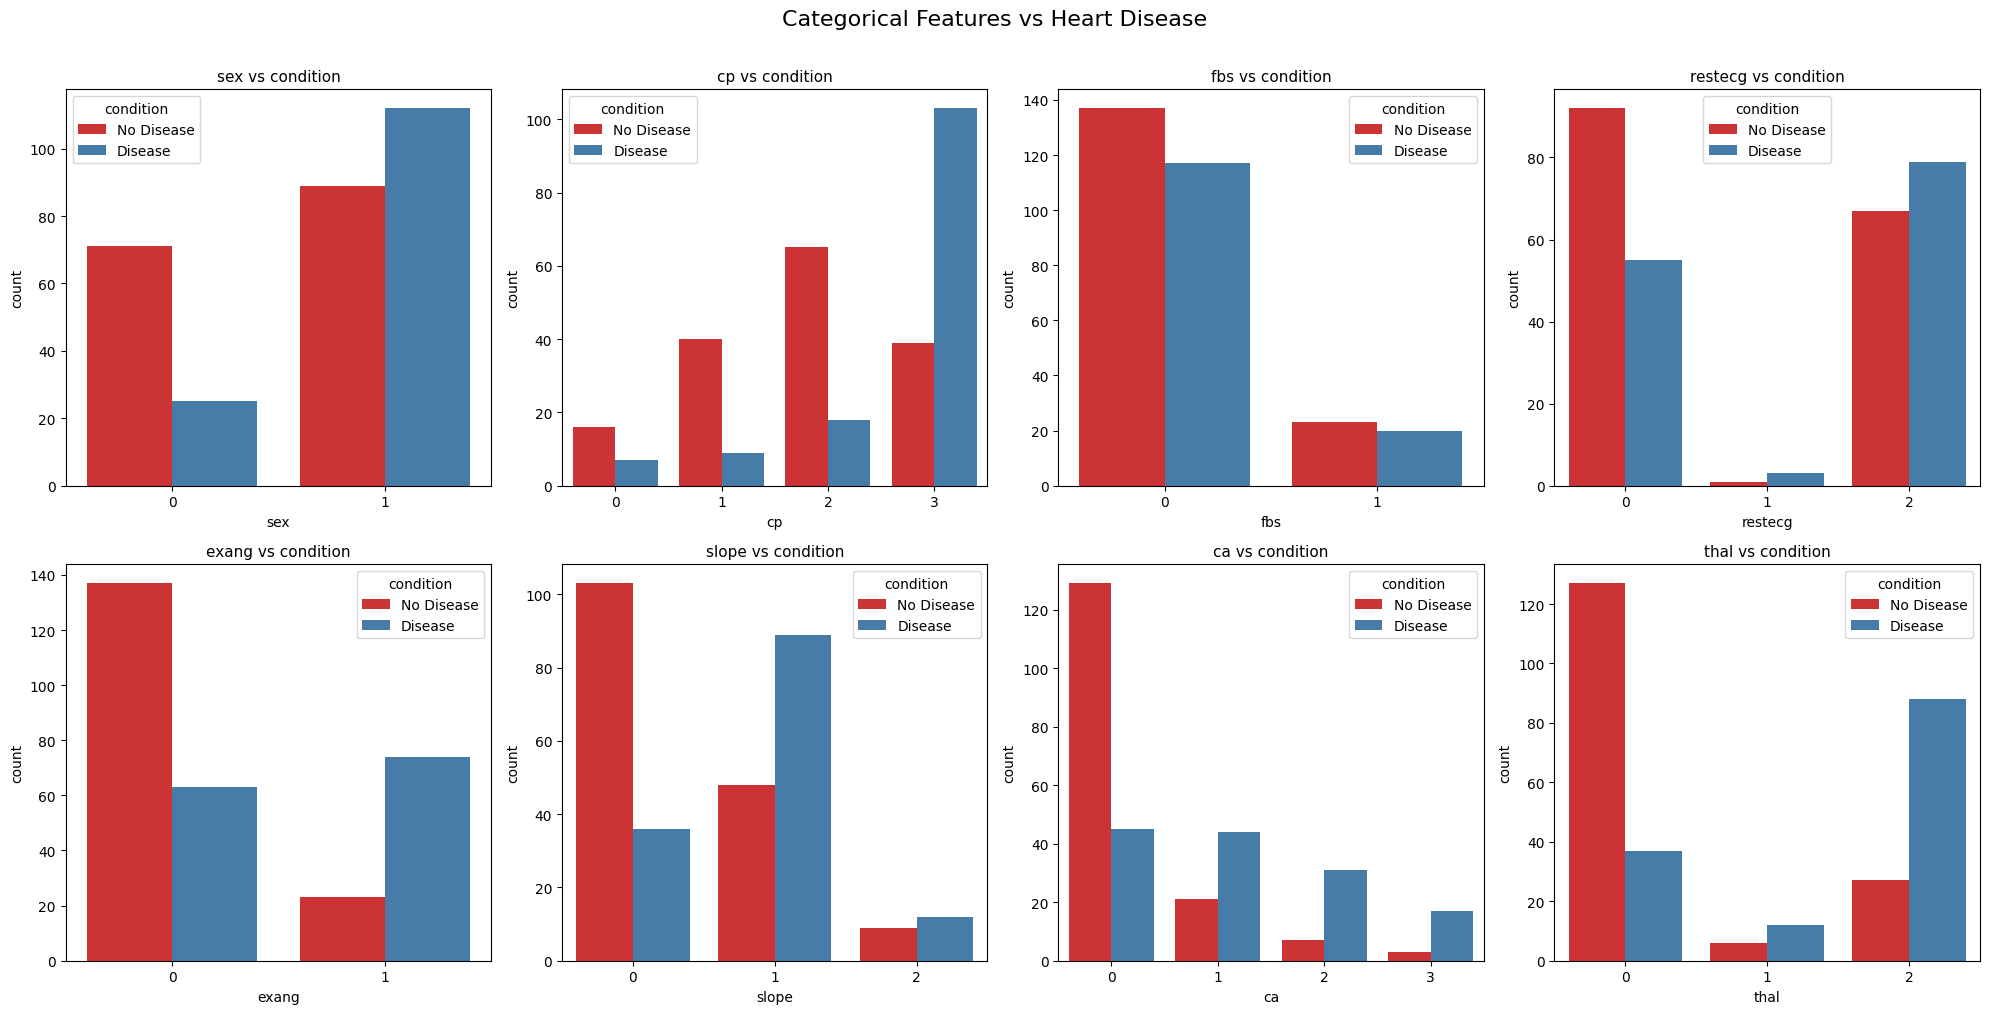

In [98]:
categorical_feats = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()
for i, col in enumerate(categorical_feats):
    sns.countplot(data=df, x=col, hue='condition', ax=axes[i], palette='Set1')
    axes[i].set_title(f'{col} vs condition', fontsize=11)
    axes[i].legend(title='condition', labels=['No Disease', 'Disease'])
plt.suptitle('Categorical Features vs Heart Disease', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

## Feature Engineering

In [99]:
# Encode categorical variables (I am using one-hot encoding) 
df_eng = df.copy()

nominal_cols = ['cp', 'restecg', 'slope', 'thal']
df_eng = pd.get_dummies(df_eng, columns=nominal_cols, drop_first=True, dtype=int)

print(f"Shape after one-hot encoding: {df_eng.shape}")
df_eng.head()

Shape after one-hot encoding: (297, 19)


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,condition,cp_1,cp_2,cp_3,restecg_1,restecg_2,slope_1,slope_2,thal_1,thal_2
0,69,1,160,234,1,131,0,0.1,1,0,0,0,0,0,1,1,0,0,0
1,69,0,140,239,0,151,0,1.8,2,0,0,0,0,0,0,0,0,0,0
2,66,0,150,226,0,114,0,2.6,0,0,0,0,0,0,0,0,1,0,0
3,65,1,138,282,1,174,0,1.4,1,1,0,0,0,0,1,1,0,0,0
4,64,1,110,211,0,144,1,1.8,0,0,0,0,0,0,1,1,0,0,0


In [100]:
# Try to find outlier and handling it outliers using IQR capping 
continuous_feats = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

def cap_outliers(series, factor=1.5):
    Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - factor * IQR, Q3 + factor * IQR
    return series.clip(lower, upper)

outlier_counts = {}
for col in continuous_feats:
    before = ((df_eng[col] < df_eng[col].quantile(0.25) - 1.5 * (df_eng[col].quantile(0.75) - df_eng[col].quantile(0.25))) |
              (df_eng[col] > df_eng[col].quantile(0.75) + 1.5 * (df_eng[col].quantile(0.75) - df_eng[col].quantile(0.25)))).sum()
    outlier_counts[col] = before
    df_eng[col] = cap_outliers(df_eng[col])

print("Outliers detected & capped per feature:")
for col, cnt in outlier_counts.items():
    print(f"  {col}: {cnt} outliers capped")

Outliers detected & capped per feature:
  age: 0 outliers capped
  trestbps: 9 outliers capped
  chol: 5 outliers capped
  thalach: 1 outliers capped
  oldpeak: 5 outliers capped


In [101]:

df_eng['age_x_oldpeak'] = df_eng['age'] * df_eng['oldpeak']       # older patients with ST depression
df_eng['thalach_x_exang'] = df_eng['thalach'] * df_eng['exang']   # max HR during exercise angina
df_eng['trestbps_x_chol'] = df_eng['trestbps'] * df_eng['chol']   # blood pressure × cholesterol risk
df_eng['age_x_thalach'] = df_eng['age'] * df_eng['thalach']       # age-adjusted max heart rate

print(f"Shape after interaction features: {df_eng.shape}")
print("New features:", ['age_x_oldpeak', 'thalach_x_exang', 'trestbps_x_chol', 'age_x_thalach'])

Shape after interaction features: (297, 23)
New features: ['age_x_oldpeak', 'thalach_x_exang', 'trestbps_x_chol', 'age_x_thalach']


In [102]:
# Scale / normalize numerical features
X = df_eng.drop('condition', axis=1)
y = df_eng['condition']

# Identifying the  numerical columns to scale
num_cols_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak',
                     'age_x_oldpeak', 'thalach_x_exang', 'trestbps_x_chol', 'age_x_thalach']

scaler = StandardScaler()
X[num_cols_to_scale] = scaler.fit_transform(X[num_cols_to_scale])

print("Numerical columns scaled (StandardScaler):", num_cols_to_scale)
print(f"\nFinal feature matrix shape: {X.shape}")
X.head()

Numerical columns scaled (StandardScaler): ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'age_x_oldpeak', 'thalach_x_exang', 'trestbps_x_chol', 'age_x_thalach']

Final feature matrix shape: (297, 22)


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,cp_1,...,restecg_1,restecg_2,slope_1,slope_2,thal_1,thal_2,age_x_oldpeak,thalach_x_exang,trestbps_x_chol,age_x_thalach
0,1.600302,1,1.708484,-0.256741,1,-0.818700,0,-0.844856,1,0,...,0,1,1,0,0,0,-0.805554,-0.684472,0.617171,0.653254
1,1.600302,0,0.516098,-0.152042,0,0.059667,0,0.682965,2,0,...,0,0,0,0,0,0,1.017279,-0.684472,0.123998,1.593912
2,1.268242,0,1.112291,-0.424258,0,-1.565312,0,1.401940,0,0,...,0,0,0,1,0,0,1.753871,-0.684472,0.178520,-0.379425
3,1.157555,1,0.396860,0.748366,1,1.069789,0,0.323478,1,0,...,0,1,1,0,0,0,0.501353,-0.684472,0.800066,2.201250
4,1.046868,1,-1.272481,-0.738354,0,-0.247762,1,0.682965,0,0,...,0,1,1,0,0,0,0.877419,1.519027,-1.146107,0.773904


In [103]:
# Data set summary after EDA and analysis
print("SUMMARY")
print(f"Original shape of Dataset:    {df.shape}")
print(f"After preprocessing and EDA shape:  X={X.shape}, y={y.shape}")
print(f"\nCategorical encoding: One-hot on {['cp', 'restecg', 'slope', 'thal']}")
print(f"Outlier handling:    IQR capping on {continuous_feats}")
print(f"Interaction features: age×oldpeak, thalach×exang, trestbps×chol, age×thalach")
print(f"Scaling:             StandardScaler on {len(num_cols_to_scale)} numerical columns")
print(f"\nTarget distribution:")
print(y.value_counts().rename({0: 'No Disease', 1: 'Disease'}))

SUMMARY
Original shape of Dataset:    (297, 14)
After preprocessing and EDA shape:  X=(297, 22), y=(297,)

Categorical encoding: One-hot on ['cp', 'restecg', 'slope', 'thal']
Outlier handling:    IQR capping on ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Interaction features: age×oldpeak, thalach×exang, trestbps×chol, age×thalach
Scaling:             StandardScaler on 9 numerical columns

Target distribution:
condition
No Disease    160
Disease       137
Name: count, dtype: int64


## Model Building

Train set (before SMOTE): 237 samples
Test set:  60 samples
Train target ratio (before): {0: 128, 1: 109}

Train set (after SMOTE): 256 samples
Train target ratio (after):  {1: 128, 0: 128}


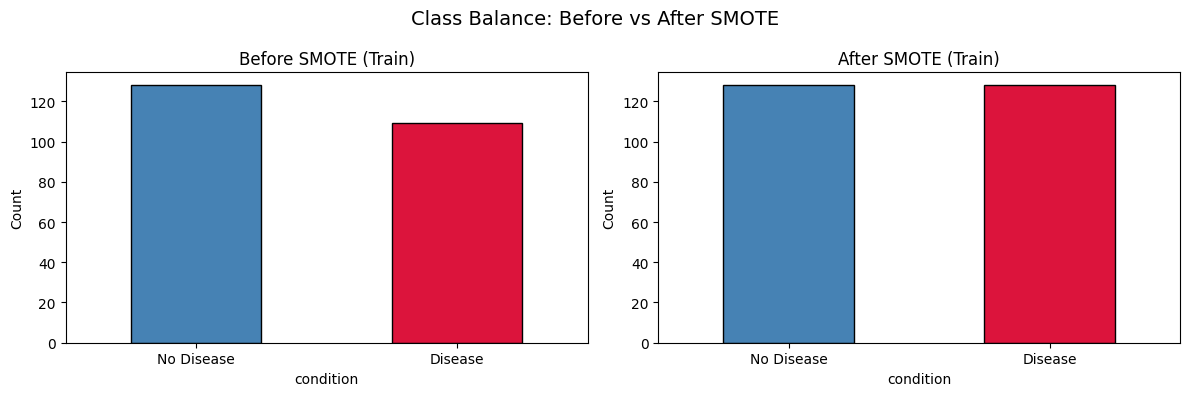

In [104]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, roc_auc_score, roc_curve, accuracy_score)
from xgboost import XGBClassifier

# --- Train-Test Split (80-20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train set (before SMOTE): {X_train.shape[0]} samples")
print(f"Test set:  {X_test.shape[0]} samples")
print(f"Train target ratio (before): {y_train.value_counts().to_dict()}")

# --- Apply SMOTE on training data only (avoid data leakage) 
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print(f"\nTrain set (after SMOTE): {X_train_sm.shape[0]} samples")
print(f"Train target ratio (after):  {pd.Series(y_train_sm).value_counts().to_dict()}")

# to visualize before vs after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'crimson'], edgecolor='black')
axes[0].set_title('Before SMOTE (Train)')
axes[0].set_xticklabels(['No Disease', 'Disease'], rotation=0)
axes[0].set_ylabel('Count')

pd.Series(y_train_sm).value_counts().plot(kind='bar', ax=axes[1], color=['steelblue', 'crimson'], edgecolor='black')
axes[1].set_title('After SMOTE (Train)')
axes[1].set_xticklabels(['No Disease', 'Disease'], rotation=0)
axes[1].set_ylabel('Count')
plt.suptitle('Class Balance: Before vs After SMOTE', fontsize=14)
plt.tight_layout()
plt.show()

### Model 1: Logistic Regression (all features)

In [105]:
# --- Logistic Regression ---
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Metrics
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_proba_lr)
lr_acc = accuracy_score(y_test, y_pred_lr)

print("=" * 50)
print("LOGISTIC REGRESSION — All Features")
print("=" * 50)
print(f"Accuracy:  {lr_acc:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")
print(f"AUC-ROC:   {lr_auc:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_lr, target_names=['No Disease', 'Disease'])}")

# Cross-validation
cv_scores_lr = cross_val_score(lr_model, X, y, cv=5, scoring='f1')
print(f"5-Fold CV F1: {cv_scores_lr.mean():.4f} ± {cv_scores_lr.std():.4f}")

LOGISTIC REGRESSION — All Features
Accuracy:  0.7833
F1-Score:  0.7719
AUC-ROC:   0.8371

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.81      0.78      0.79        32
     Disease       0.76      0.79      0.77        28

    accuracy                           0.78        60
   macro avg       0.78      0.78      0.78        60
weighted avg       0.78      0.78      0.78        60

5-Fold CV F1: 0.7509 ± 0.1869


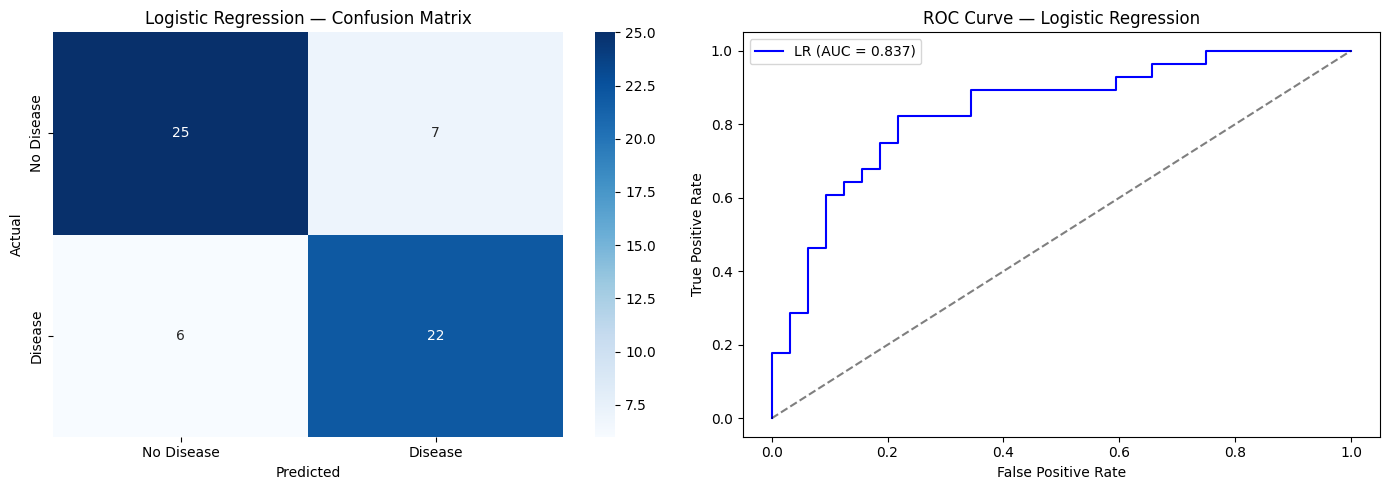

In [106]:
# Confusion Matrix — Logistic Regression
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
axes[0].set_title('Logistic Regression — Confusion Matrix')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
axes[1].plot(fpr_lr, tpr_lr, 'b-', label=f'LR (AUC = {lr_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_title('ROC Curve — Logistic Regression')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()
plt.tight_layout()
plt.show()

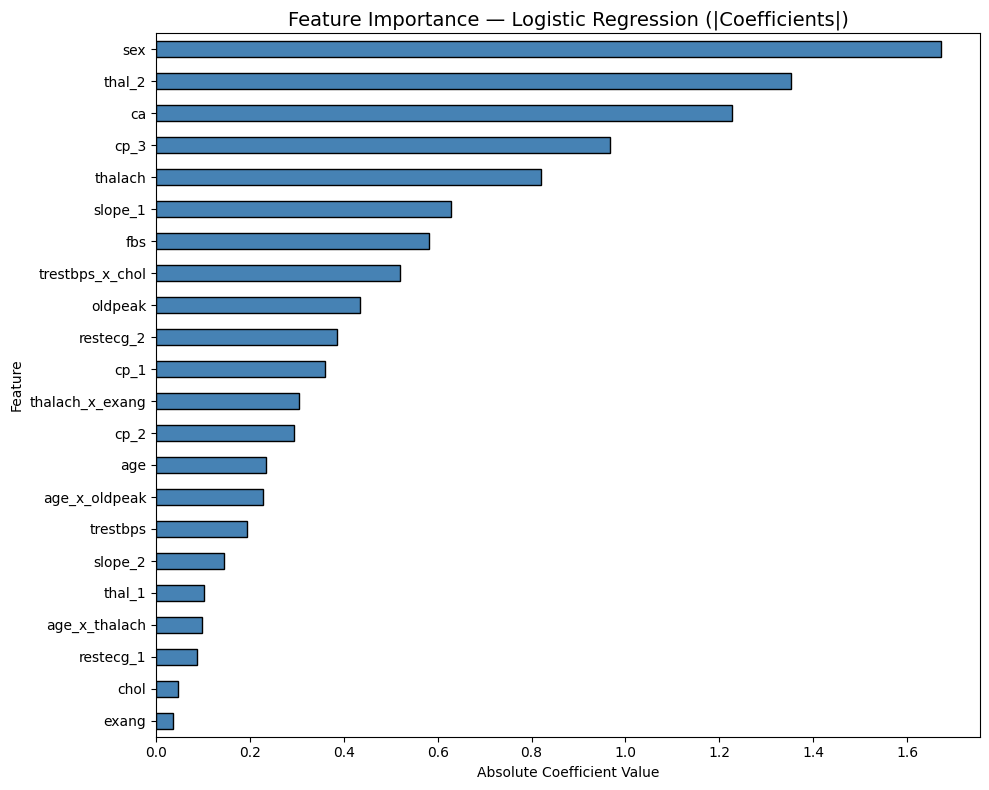

Top 10 most important features (LR):
  sex                       1.6715
  thal_2                    1.3530
  ca                        1.2276
  cp_3                      0.9676
  thalach                   0.8190
  slope_1                   0.6281
  fbs                       0.5810
  trestbps_x_chol           0.5196
  oldpeak                   0.4353
  restecg_2                 0.3863


In [115]:
# Feature Importance — Logistic Regression (coefficient magnitudes)
feature_names = X.columns
lr_coefs = pd.Series(np.abs(lr_model.coef_[0]), index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, 8))
lr_coefs.plot(kind='barh', color='steelblue', edgecolor='black')
plt.title('Feature Importance — Logistic Regression (|Coefficients|)', fontsize=14)
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Top 10 most important features (LR):")
for feat, val in lr_coefs.tail(10)[::-1].items():
    print(f"  {feat:25s} {val:.4f}")

### Model 2: XGBoost Classifier (to improve over Logistic Regression)

In [111]:
# --- XGBoost with Hyperparameter Tuning (RandomizedSearchCV)
# Using scale_pos_weight instead of SMOTE to handle class imbalance 
from sklearn.model_selection import RandomizedSearchCV

# Calculate scale_pos_weight for imbalance handling
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
spw = neg_count / pos_count

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.08, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0],
    'scale_pos_weight': [1, spw, spw * 0.75],
}

xgb_base = XGBClassifier(eval_metric='logloss', random_state=42)

search = RandomizedSearchCV(
    xgb_base, param_dist, n_iter=80, scoring='f1',
    cv=5, random_state=42, n_jobs=-1
)
search.fit(X_train, y_train)

print(f"Best CV F1: {search.best_score_:.4f}")
print(f"Best params: {search.best_params_}")

# Use the best model
xgb_model = search.best_estimator_
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Metrics
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_proba_xgb)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

print("\n" + "=" * 50)
print("XGBOOST CLASSIFIER — Tuned (scale_pos_weight)")
print("=" * 50)
print(f"Accuracy:  {xgb_acc:.4f}")
print(f"F1-Score:  {xgb_f1:.4f}")
print(f"AUC-ROC:   {xgb_auc:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_xgb, target_names=['No Disease', 'Disease'])}")

# Cross-validation on full dataset
cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='f1')
print(f"5-Fold CV F1: {cv_scores_xgb.mean():.4f} ± {cv_scores_xgb.std():.4f}")

Best CV F1: 0.8477
Best params: {'subsample': 1.0, 'scale_pos_weight': 0.8807339449541285, 'reg_lambda': 1.0, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}

XGBOOST CLASSIFIER — Tuned (scale_pos_weight)
Accuracy:  0.7333
F1-Score:  0.7241
AUC-ROC:   0.8002

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.77      0.72      0.74        32
     Disease       0.70      0.75      0.72        28

    accuracy                           0.73        60
   macro avg       0.73      0.73      0.73        60
weighted avg       0.74      0.73      0.73        60

5-Fold CV F1: 0.6451 ± 0.2695


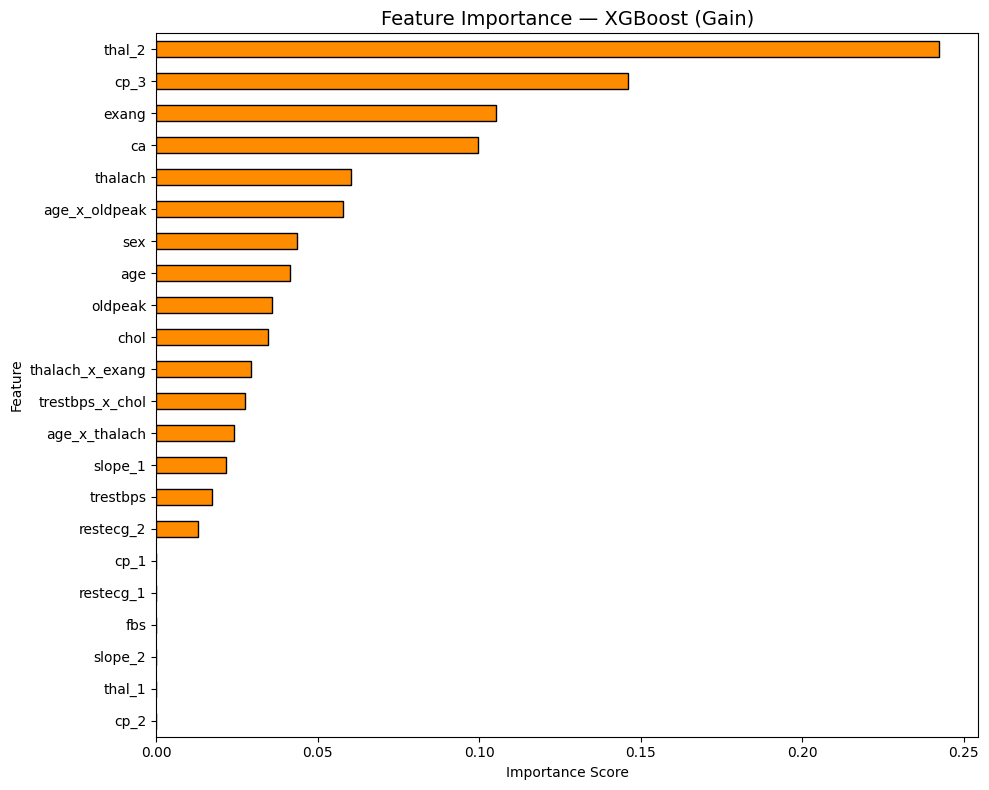

Top 10 most important features (XGBoost):
  thal_2                    0.2424
  cp_3                      0.1460
  exang                     0.1053
  ca                        0.0997
  thalach                   0.0603
  age_x_oldpeak             0.0580
  sex                       0.0435
  age                       0.0414
  oldpeak                   0.0360
  chol                      0.0347


In [112]:
# XGBoost Feature Importance Plot
importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(10, 8))
importances.plot(kind='barh', color='darkorange', edgecolor='black')
plt.title('Feature Importance — XGBoost (Gain)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Top 10 most important features (XGBoost):")
for feat, val in importances.tail(10)[::-1].items():
    print(f"  {feat:25s} {val:.4f}")

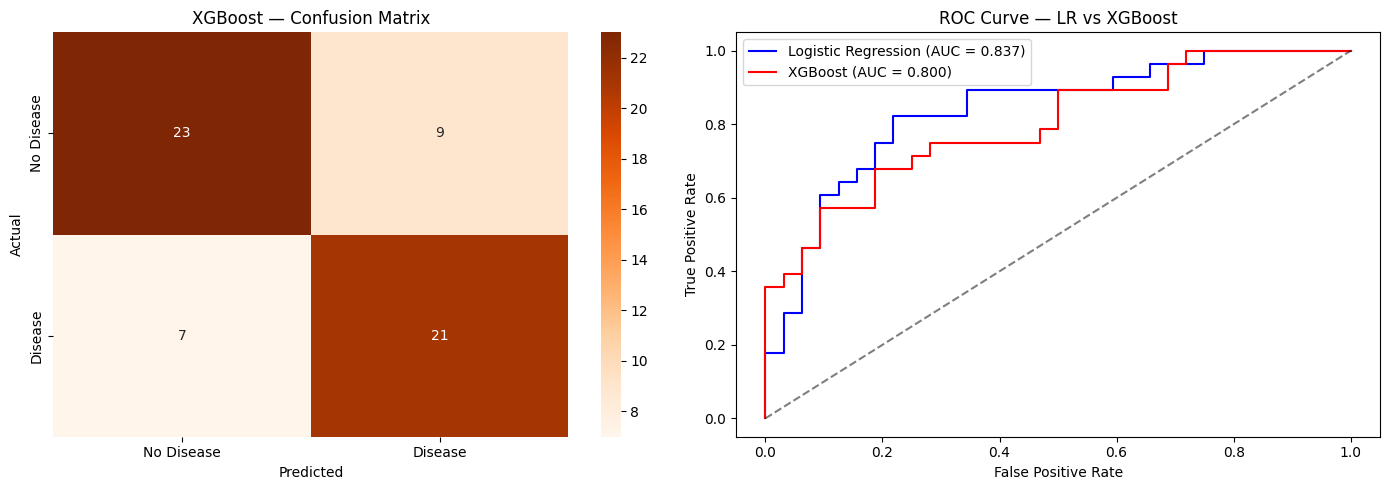

In [113]:
# Confusion Matrix & ROC Curve — XGBoost
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', ax=axes[0],
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
axes[0].set_title('XGBoost — Confusion Matrix')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# ROC Curve — both models overlaid
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
axes[1].plot(fpr_lr, tpr_lr, 'b-', label=f'Logistic Regression (AUC = {lr_auc:.3f})')
axes[1].plot(fpr_xgb, tpr_xgb, 'r-', label=f'XGBoost (AUC = {xgb_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_title('ROC Curve — LR vs XGBoost')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()
plt.tight_layout()
plt.show()

MODEL COMPARISON
                     Logistic Regression   XGBoost
Metric                                            
Accuracy                        0.783333  0.733333
F1-Score                        0.771930  0.724138
AUC-ROC                         0.837054  0.800223
5-Fold CV F1 (mean)             0.750940  0.645124


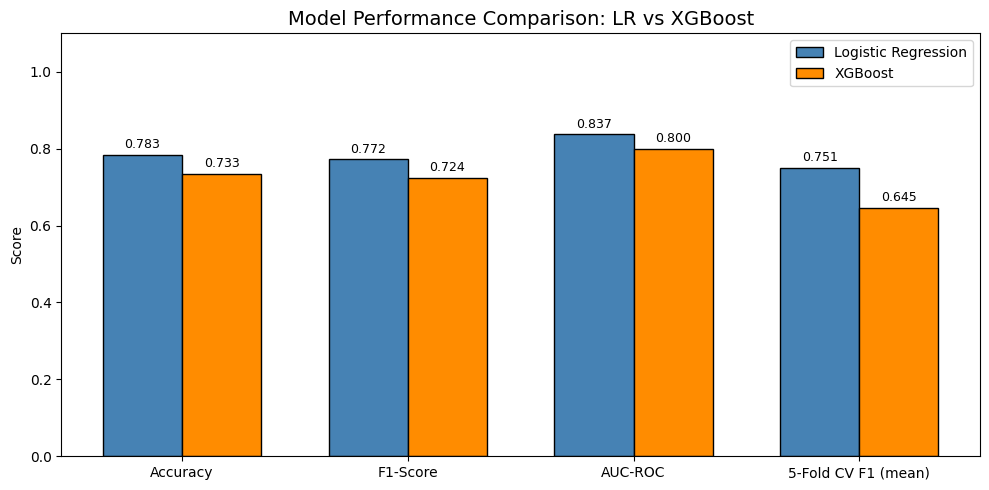


Best performing model: Logistic Regression


In [114]:
# --- Model Comparison: Logistic Regression vs XGBoost ---
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Score', 'AUC-ROC', '5-Fold CV F1 (mean)'],
    'Logistic Regression': [lr_acc, lr_f1, lr_auc, cv_scores_lr.mean()],
    'XGBoost': [xgb_acc, xgb_f1, xgb_auc, cv_scores_xgb.mean()]
})
comparison = comparison.set_index('Metric')
print("=" * 55)
print("MODEL COMPARISON")
print("=" * 55)
print(comparison.to_string())

# Visual comparison
metrics = ['Accuracy', 'F1-Score', 'AUC-ROC', '5-Fold CV F1 (mean)']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, comparison['Logistic Regression'], width, label='Logistic Regression', color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, comparison['XGBoost'], width, label='XGBoost', color='darkorange', edgecolor='black')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison: LR vs XGBoost', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{bar.get_height():.3f}',
            ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{bar.get_height():.3f}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

best_model = "XGBoost" if xgb_f1 > lr_f1 else "Logistic Regression"
print(f"\nBest performing model: {best_model}")